# Sentiment Analysis

*Prepared by Sebastian C. Ibañez*

--- 

<a href="https://colab.research.google.com/github/aim-msds/msds2022-ml3/blob/main/notebooks/05_RNN/03_sentiment-analysis.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="float: left;"></a><br>

In this notebook, our goal is to create a sentiment classifier using an LSTM.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import os
import re
import string

## Loading the Data

In [2]:
dataset_dir = 'data/aclImdb'
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [3]:
# Check the vocab
vocab = open('data/aclImdb/imdb.vocab', 'rb').read().decode(encoding='utf-8', errors='ignore').split('\n')
vocab_size = len(vocab)

print(f'Sample: {vocab[:10]}')
print(f'Number of unique tokens: {vocab_size}')

Sample: ['the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this']
Number of unique tokens: 89527


In [4]:
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

print(os.listdir(train_dir))
print(os.listdir(test_dir))

# Delete unsup folder

['labeledBow.feat', 'neg', 'pos', 'unsupBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']
['labeledBow.feat', 'neg', 'pos', 'urls_neg.txt', 'urls_pos.txt']


In [5]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [6]:
batch_size = 64 # choose smaller batch size if you are getting OOM errors
seed = 12 # makes sure that theres no leakage between train and val

# Iterable for training batches
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    directory=train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Note that `tf.keras.utils.text_dataset_from_directory` requires the directory structure to be as follows,

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

In [7]:
# Which label is which?
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print('---')

# Take 1 batch
for text_batch, label_batch in raw_train_ds.take(1):
    # Print first 3 elements in batch
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])
        print('---')

Label 0 corresponds to neg
Label 1 corresponds to pos
---
Review b'Oh my, I think this may be the single cheesiest movie I\'ve ever seen. I\'m serious, this is one of the ultimate b-movies. The first proof is that it isn\'t a $5 DVD. Oh no, that\'s too mainstream for this. I got this on VHS, from a bin full of ex-rental videos at my local video store.<br /><br />If I may quote the blurb: "In 17th Century Japan, there lived a samurai who would set the standard for the ages. His name was Mayeda. He is sent on an epic journey across the world to acquire 5,000 muscats from the King of Spain. Whilst at sea a violent storm swallows their precious gold intended to buy the weapons and almost takes their lives. Mayeda must battle all odds to survive and the secure the fate of his beloved Japan." It then goes on to say "A multi million dollar action adventure epic set across three continents"<br /><br />I must have seen a different movie. This was no epic, and it certainly wasn\'t a multi millio

In [8]:
# Iterable for val batches
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    directory=train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

# Iterable for test batches
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    directory=test_dir,
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


## Tokenization and Preprocessing

In [9]:
# We need to make a custom rule to remove HTML tags
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data) # make lower case
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # remove HTML tag
    output_data = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '') # remove punctuations
    return output_data

In [10]:
# Hyperparams
max_tokens = 10000 # this can be smaller than the actual vocab size for faster processing
max_length = 250 # max sequence length, will either pad or truncate sentences

# Create a TextVectorization layer to do the pre-processing
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_tokens,
    output_sequence_length=max_length
)

train_text = raw_train_ds.map(lambda x, y: x) # get the text
vectorize_layer.adapt(train_text) # "fit" the layer

In [11]:
vocab = np.array(vectorize_layer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film'],
      dtype='<U17')

In [12]:
# vectorize text using the custom layer
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1) # reshape to (batch, sequence, features)
    return vectorize_layer(text), label

# retrieve a batch from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'This film is advertised as a clever romantic comedy. It is neither clever nor romantic and it is definitely not an effective comedy. The fortunes of the well meaning yet pathetic character, "Tom", oscillate from one extremely embarrassing disaster to another. The only saving graces are the competent performance by Toni Collete and the frequency with which we glimpse Paltrow\'s pleasant face. Overall, to be avoided!', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  11,   19,    7, 5884,   14,    4, 1040,  736,  217,    9,    7,
        1042, 1040,  869,  736,    3,    9,    7,  390,   21,   33, 1106,
         217,    2,    1,    5,    2,   73, 1230,  241, 1176,  106,  820,
           1,   35,   28,  569, 2180, 1671,    6,  154,    2,   60, 1877,
        8883,   23,    2, 3279,  226,   32, 6541,    1,    3,    2,    1,
          16,   61,   70, 3183,    1, 2058,  402,  429,    6,   27, 4069,
           0,  

In [13]:
# reverse lookup example
print("123 ---> ",vectorize_layer.get_vocabulary()[123])
print("500 ---> ",vectorize_layer.get_vocabulary()[500])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

123 --->  your
500 --->  game
Vocabulary size: 10000


In [14]:
# vectorize the train, val, and test data
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Autotuning for I/O Performance

Read more about it [here](https://www.tensorflow.org/guide/data_performance).

In [15]:
# Tuning caching and stuff of dataset, especially useful if the dataset is big and has to be constantly read from disk
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building

In [16]:
# Hyperparams
embedding_dim = 16
hidden_units = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_tokens,
                              embedding_dim,
                              mask_zero=True), # IMPORTANT: tells sequence processing layers (like the LSTM below) to ignore padding!
    tf.keras.layers.LSTM(hidden_units, return_sequences=False),
    #tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 162,129
Trainable params: 162,129
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Loss, optimizer, and metric
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # no softmax/sigmoid at the end
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # learning rate is something that should definitely be tuned!!!
              metrics=['acc'])

In [18]:
# Model checkpoint
checkpoint_filepath = 'training_checkpoints/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True,
    verbose=False)

In [19]:
# train the model
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[model_checkpoint_callback]) # can also try swapping out for early stopping

Epoch 1/10
313/313 [==============================] - 8s 17ms/step - loss: 0.5498 - acc: 0.6447 - val_loss: 0.4012 - val_acc: 0.8076
Epoch 2/10
313/313 [==============================] - 4s 12ms/step - loss: 0.3000 - acc: 0.8786 - val_loss: 0.3341 - val_acc: 0.8482
Epoch 3/10
313/313 [==============================] - 4s 12ms/step - loss: 0.2193 - acc: 0.9173 - val_loss: 0.3432 - val_acc: 0.8590
Epoch 4/10
313/313 [==============================] - 4s 12ms/step - loss: 0.1826 - acc: 0.9342 - val_loss: 0.3680 - val_acc: 0.8640
Epoch 5/10
313/313 [==============================] - 4s 12ms/step - loss: 0.1781 - acc: 0.9362 - val_loss: 0.4075 - val_acc: 0.8650
Epoch 6/10
313/313 [==============================] - 4s 12ms/step - loss: 0.1720 - acc: 0.9369 - val_loss: 0.3971 - val_acc: 0.8544
Epoch 7/10
313/313 [==============================] - 4s 12ms/step - loss: 0.1298 - acc: 0.9536 - val_loss: 0.4487 - val_acc: 0.8558
Epoch 8/10
313/313 [==============================] - 4s 12ms/step - 

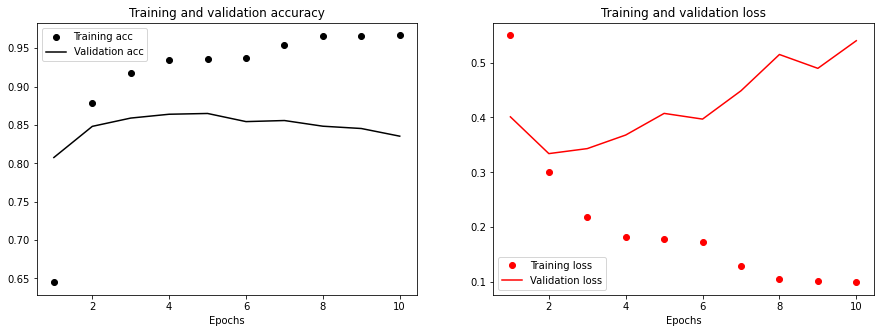

In [20]:
history_dict = history.history
history_dict.keys()

def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    ax2.plot(epochs, loss, 'ro', label='Training loss')
    ax2.plot(epochs, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()
    
    # plot accuracy 
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    ax1.plot(epochs, acc, 'ko', label='Training acc')
    ax1.plot(epochs, val_acc, 'k', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

plot_results(history)

In [21]:
# load best weights
model.load_weights(checkpoint_filepath)

loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

391/391 [==============================] - 3s 7ms/step - loss: 0.4351 - acc: 0.8498
Loss:  0.43509846925735474
Accuracy:  0.8497999906539917


## Add `TextVectorization` Layer to the Model

In [22]:
final_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    tf.keras.layers.Activation('sigmoid')
])

final_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), # we added a sigmoid at the end
                    optimizer='adam',
                    metrics=['acc'])

loss, accuracy = final_model.evaluate(raw_test_ds) # now we can pass the "raw" test dataset
print(accuracy)

391/391 [==============================] - 5s 11ms/step - loss: 0.4351 - acc: 0.8500
0.8499600291252136


## Inference on New Data

In [23]:
sample = [
    'The movie was great.',
    'The movie was good.',
    'The movie was ok.',
    'The movie was bad.',
    'The movie was terrible.',
    'thisisgibberishlol'
]

for sample, pred in zip(sample, final_model.predict(sample)):
    print(f'{sample} --> {pred}')

The movie was great. --> [0.7565752]
The movie was good. --> [0.6183945]
The movie was ok. --> [0.3494641]
The movie was bad. --> [0.22280394]
The movie was terrible. --> [0.18135598]
thisisgibberishlol --> [0.514967]


## References

---

[1] https://www.tensorflow.org/tutorials/keras/text_classification

[2] https://www.tensorflow.org/text/tutorials/text_classification_rnn